In [66]:
import yaml
import os
import re
import random
import json

with open("config.yaml", "r") as yamlfile:
    conf = yaml.load(yamlfile, Loader=yaml.FullLoader)

START_CH = conf['CHARS']['START']
PAD_CH = conf['CHARS']['PAD']
OOV_CH = conf['CHARS']['OOV']
MAX_SENTENCE = 250

CHR_IDX_PATH = conf['CHAR_INDEX']
chr_idx = {}

with open(CHR_IDX_PATH, 'r', encoding='utf-8') as f_in:
    chr_idx = json.load(f_in)

idx_chr = [''] * len(chr_idx)
for ch, i in chr_idx.items():
    idx_chr[i] = ch

# Preparation

In [70]:
actuals = []
maskeds = []

def masked_chars(chs):
    res = [ch for ch in chs]
    for i in range(len(chs)):
        if random.random() < 0.25:
            if random.random() > 0.7:
                rand_idx = random.randint(0, len(chs)-1)
                res[i] = chs[rand_idx]
            else:
                res[i] = idx_chr[random.randint(0, len(idx_chr)-1)]
    return res  

for fn in os.listdir(conf['Data']['BEST_ARTICLE']):
    with open(os.path.join(conf['Data']['BEST_ARTICLE'], fn), 'r', encoding='utf-8') as f_in:
        data = f_in.read()
    data = data.replace('|', '')
    data = re.sub(r'<.+>','',data)
    data = data.replace(r'ํา', 'ำ')
    sentences = data.split('\n')
    
    truncated_sentence = []
    for sent in sentences:
        if len(sent) < MAX_SENTENCE:
            truncated_sentence.append(sent)
            continue
            
        ss = sent.split(' ')
        i = 0
        while i < len(ss):
            if len(ss[i]) >= MAX_SENTENCE:
                raise Exception(f'subsentence length is more than {MAX_SENTENCE}; {len(ss[i])}')
            
            _s = ss[i]
            j = i+1
            while j < len(ss) and len(_s) + len(ss[j]) + 1 < MAX_SENTENCE:
                _s += " " + ss[j]
                j += 1
            
            truncated_sentence.append(_s)
            i = j
    
    for s in truncated_sentence:
        chs = list(map(lambda x: x if x in chr_idx else OOV_CH,[x for x in s]))
        actuals.append([START_CH] + chs)
        maskeds.append([START_CH] + masked_chars(chs))

In [71]:
print(actuals[0])
print(maskeds[0])

['[CLS]', 'ก', 'ฎ', 'ห', 'ม', 'า', 'ย', 'ก', 'ั', 'บ', 'ก', 'า', 'ร', 'เ', 'บ', 'ี', 'ย', 'ด', 'บ', 'ั', 'ง', 'ค', 'น', 'จ', 'น']
['[CLS]', 'ก', 'g', 'ห', 'ม', 'า', 'ย', 'ก', '๓', 'บ', 'ก', 'า', 'D', 'เ', 'ส', '฿', 'ย', 'ด', 'บ', 'ั', 'ง', 'ค', 'น', 'จ', 'ึ']


In [72]:
oov = set()
for actual in actuals:
    for x in actual:
        if x not in chr_idx:
            oov.add(x)
print(oov)

set()


In [73]:
max_len = 0
for actual in actuals:
    max_len = max(max_len, len(actual))
print('maximum sentence length: ', max_len)
print('number of test', len(actuals))

maximum sentence length:  250
number of test 24842


# Training

In [74]:
import tensorflow as tf
from tqdm.keras import TqdmCallback

X = [[chr_idx[x] if x in chr_idx else chr_idx['[OOV]'] for x in masked] for masked in maskeds]
X = tf.keras.preprocessing.sequence.pad_sequences(
    X, 
    padding='post', 
    maxlen=max_len,
    value=chr_idx[PAD_CH],
)
y = [[chr_idx[x] if x in chr_idx else chr_idx['[OOV]'] for x in actual] for actual in actuals]
y = tf.keras.preprocessing.sequence.pad_sequences(
    y, 
    padding='post', 
    maxlen=max_len,
    value=chr_idx[PAD_CH],
)
y = tf.one_hot(y, len(chr_idx))

In [64]:
# https://keras.io/examples/nlp/masked_language_modeling/
model = tf.keras.Sequential([
    tf.keras.Input(shape=(max_len,)),
    tf.keras.layers.Embedding(
        len(chr_idx), 
        output_dim=100,
        embeddings_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.2)
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
    tf.keras.layers.Dense(len(chr_idx)),
    tf.keras.layers.Softmax(),
])
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 250, 100)          17700     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 250, 600)          962400    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 250, 200)          560800    
_________________________________________________________________
dense_4 (Dense)              (None, 250, 177)          35577     
_________________________________________________________________
softmax_4 (Softmax)          (None, 250, 177)          0         
Total params: 1,576,477
Trainable params: 1,576,477
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.compile(optimizer='adam', loss='categorical_crossentropy')
history = model.fit(X,y, epochs=20, verbose=0, callbacks=[TqdmCallback(verbose=1)])

# Evaluation

<Figure size 432x288 with 0 Axes>

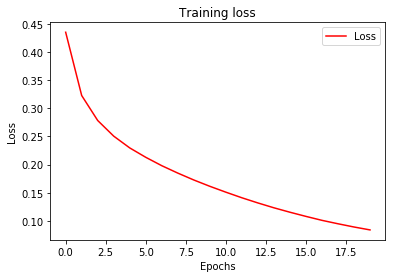

<Figure size 432x288 with 0 Axes>

In [76]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [82]:
test_id = 10
pred = model.predict([X[test_id]])
pred_arg = tf.math.argmax(pred, 2)

s = []
for x in pred_arg:
    s.append(idx_chr[int(x[0])])
print(actuals[test_id])
print(maskeds[test_id])
print(s)

['[CLS]', 'แ', 'ต', '่', 'ใ', 'น', 'ก', 'า', 'ร', 'ศ', 'ึ', 'ก', 'ษ', 'า', 'น', 'ี', '้', 'ม', 'ุ', '่', 'ง', 'ต', '้', 'อ', 'ง', 'ก', 'า', 'ร', 'ท', 'ี', '่', 'จ', 'ะ', 'ส', 'ะ', 'ท', '้', 'อ', 'น', 'ภ', 'า', 'พ', 'ค', 'ว', 'า', 'ม', 'ไ', 'ม', '่', 'ส', 'ม', 'ด', 'ุ', 'ล', ' ', 'ค', 'ว', 'า', 'ม', 'ไ', 'ม', '่', 'เ', 'ส', 'ม', 'อ', 'ภ', 'า', 'ค', ' ', 'ห', 'ร', 'ื', 'อ', 'ค', 'ว', 'า', 'ม', 'ไ', 'ม', '่', 'เ', 'ท', '่', 'า', 'เ', 'ท', 'ี', 'ย', 'ม', ' ', 'ท', 'ี', '่', 'ม', 'ี', 'อ', 'ย', 'ู', '่', 'ใ', 'น', 'ค', 'ว', 'า', 'ม', 'เ', 'ป', '็', 'น', 'จ', 'ร', 'ิ', 'ง', ' ', 'แ', 'ต', '่', 'ถ', 'ู', 'ก', 'ต', 'ั', 'ด', 'ต', 'อ', 'น', ' ', 'ป', 'ิ', 'ด', 'ป', 'า', 'ก', ' ', 'ไ', 'ม', '่', 'ส', 'า', 'ม', 'า', 'ร', 'ถ', 'น', 'ำ', 'ม', 'า', 'อ', '้', 'า', 'ง', 'ไ', 'ด', '้', 'ใ', 'น', 'ท', 'า', 'ง', 'ก', 'ฎ', 'ห', 'ม', 'า', 'ย', ' ', 'ภ', 'า', 'ย', 'ใ', 'ต', '้', 'ก', 'ฎ', 'ห', 'ม', 'า', 'ย']
['[CLS]', 'แ', 'ต', '่', 'ใ', 'น', 'ก', 'V', 'ร', 'ศ', 'ึ', 'ก', 'ษ', 'า', 'น', '<', '้', '@', '๘', 

In [83]:
arg_score = sorted(list(range(len(chr_idx))), key=lambda x: pred[12][0][x], reverse=True)
for i, idx in enumerate(arg_score):
    if i > 10:
        break
    print(idx, idx_chr[idx], pred[12][0][idx])

1 [CLS] 0.1826175
156 - 0.10686393
154 [ 0.10447237
95 ษ 0.082743555
138 ๒ 0.07361249
76 ด 0.027698735
64 จ 0.019802215
115 โ 0.017759051
113 เ 0.017371649
35 E 0.01635566
101 ฯ 0.016289044


# Conclusion

This model doesn't work. The model itself doesn't try to change incorrect characters. This is may be because

- inappropriate loss function.
- small number of epoches.
- too much masked characters.

In doing an experiment, smaller testcase should be used.